# Identifying Pneumonia with Deep Learning
***
Author: Andre Layton
***

# Overview
Artificial Intelligence (A.I.) has grown at a rapid rate in recent years, and has begun to creep into a myriad of industries for various uses. One such use is in medical imaging. Classification tasks are common in medical image analysis; it involves classifying medical images, such as X-rays, MRI scans, and CT scans, into different categories based on factors, like the type of image or the presence of specific structures/diseases. The aim is to use algorithms to classify medical images for assistance in diagnosis, treatment planning, and disease monitoring. The issue becomes how to correctly, or accurately, classify images - which is where deep learning models and neural networks come in handy.

This analysis will examine chest X-ray images of both healthy (referred to as "normal") and pneumonia-ridden patients in order to create a model that will accurately classify the two groups. The dataset comes from Kermany, Goldbaum et al.; and it is also available via Kaggle. The dataset is pre-split into training, testing, and validation directories, which makes loading and manipulating the data simple. The data is also prepared in a way that makes it perfect for deep learning analysis (i.e. structured data with dimensions that don't require heavy processing). There are 5,216 images in the training directory (split into "NORMAL" and "PNEUMONIA" sub-directories), as well as 624 testing images and 16 validation images, both of which are split similarly to the training directory. I increased my validation dataset by splitting the testing data in order to train the model more effectively - this would have been tough with only 16 images. You can see the steps I took in the `'validation_data_preparation.ipynb'` notebook, located in this repository. 

Once the data was loaded, I took a look at the class balance, but found an imbalance. Therefore, I applied oversampling methods on the minority class (the "NORMAL" label), then reshaped and standardized the training and validation images to prepare for modeling. I also reshaped their corresponding labels. Failing to standardize the dataset could have lead to skewed results, considering the wide range of the pixel values in the training data (e.g. \[0, 255] vs. \[0, 1] after standardizing). 

I used Keras, an effective high-level neural network (API), and TensorFlow, an end-to-end open-source deep learning framework that we run Keras on top of, in order to build my algorithms and determine the best model for image classification. I also used Scikit-learn, specifically the `KFold` validator, to cross-validate the baseline model, in order to determine a baseline accuracy level. Other modeling libraries used include `RMSNet50`, for transfer learning; `Conv2D` and `MaxPooling2D`, for a convolutional neural network; `ImageDataGenerator`, for data augmentation; and `ModelCheckpoint` along with `EarlyStopping`, to help save the best model. In addition, I did some prior research on a technique that would allow me to oversample and augment my data to give my model more to train on, while also preserving the balanced classes. This led me to the `BalancedDataGenerator` class - I cited a link to the utilized code at the bottom. 

I began by building a baseline model - a neural network with two hidden layers - with hyperparameters I selected from prior research (i.e. RMSprop as my optimizer and binary cross-entropy for my loss). The next step was to use L2-regularization in order to combat the overfitting the former model exhibited. After, I used KFold to cross-validate the training model, and determined how effective my baseline is as a classifier model. I built a Convolutional Neural Network (CNN) next due to its effectiveness in classifying images, then augmented the training data in order to create more training data. More data allows the model to combat the high variance, and thus reduce the gap between the training and validation accuracies. I ended my modeling workflow with a transfer learning approach, specifically using the `RMSNet50` CNN pre-trained network to identify the surface patterns, before freezing the base and building another model to identify the abstract features in the training data. This approach also allows for data augmentation, paving the way for further improvement. 

The augmented CNN model yielded the best validation accuracy. Luckily, the model was saved using the ModelCheckpoint technique, which was then applied to the testing images for evaluation. The model yielded 40.3% accuracy after testing 524 testing images, and 176 false negatives out of those 524 predictions; obviously, there is much room for improvement and further work.

# Business Problem
Hospital executives approved the development of a radiology department, as part of their initiative for expansion. The goal is to cut costs on outsourcing tasks by creating in-house units - starting with radiology - that utilize A.I. technology. In an effort to streamline diagnostic testing, I'm tasked with building a deep learning classifier that will accurately analyze X-ray images, which will allow their physicians to put more focus on interventional planning and patient treatment.

This project's objective is to build an algorithm that will accurately classify X-ray images (specifically chest images) between two classes ("NORMAL" and "PNEUMONIA"). I'll be using data, available on Kaggle, that was gathered by Kermany, Goldbaum et al., and can be found at the bottom of the notebook.
> Note: It is vital you run the `'validation_data_preparation.ipynb'` file prior to beginning this project, if you or another attempts to mimic the work. The file contains data preparation steps that are mentioned below. 

***
<img src="https://media.licdn.com/dms/image/D4D12AQEqfniioS4KVQ/article-cover_image-shrink_720_1280/0/1677311223167?e=2147483647&v=beta&t=loMCjRjjqYyKI72mjdbVk5_XbxRdzonIKz0qRn-BcXo" style="height:500px; width:875px" />

## Data Understanding
To begin, I import all the relevant libraries, and set a seed to be able to reproduce the results from this analysis. Next, I create objects containing the pathway for each directory so that I can begin examining the data. I use the `ImageDataGenerator` function I imported to generate the image data in each directory, and then split the datasets into two groups - images (input) and labels (output). 
> Note: In a separate notebook (`'validation_data_preparation.ipynb'`), I increased the number of validation images from 16 to 116 images, by using the `os` and `shutil` modules to move random files from the testing directories. 


In [1]:
# Import all the necessary libraries
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import get_file, Sequence
from imblearn.over_sampling import RandomOverSampler
from imblearn.tensorflow import balanced_batch_generator
from collections import Counter
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.wrappers import scikit_learn
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers, optimizers
from keras.applications import ResNet50
import os, shutil, random

# Create a seed for reproducibility
seed=24

In [2]:
# Create directory path objects
train_data_dir = 'data/chest_xray/train'
test_data_dir = 'data/chest_xray/test'
validation_dir = 'data/chest_xray/val'

# Gather and reshape the data in each directory object
train_generator = ImageDataGenerator().flow_from_directory(train_data_dir, target_size=(64, 64), batch_size=5216,
                                                           seed=seed)
test_generator = ImageDataGenerator().flow_from_directory(test_data_dir, target_size=(64, 64), batch_size=524,
                                                           seed=seed)
val_generator = ImageDataGenerator().flow_from_directory(validation_dir, target_size=(64, 64), batch_size=116,
                                                           seed=seed)

# Create the datasets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

Found 5216 images belonging to 2 classes.
Found 524 images belonging to 2 classes.
Found 116 images belonging to 2 classes.


As you can see above, there are 5,216 training images, 116 validation images (thanks to the initial data preparation), and 524 testing images. Now that the data has been loaded and split, I preview a couple of images as plots for a look at what I'll be working with.

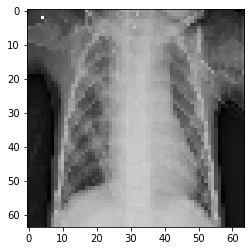

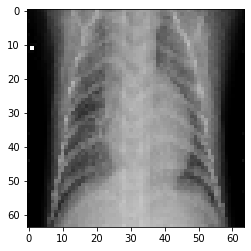

In [3]:
# Plot some images
plt.imshow(train_images[17]/255)
plt.show()

plt.imshow(train_images[4200]/255)
plt.show()

To get a better idea of my data, I also list the shape of both the images and labels for each dataset. As you can see, the images have four dimensions - the first is the number of images, the middle values represent the size of the images, and the fourth value represents the number of channels. 

In [4]:
# Preview the shape of the data
print("Train Data Shape:")
print(np.shape(train_images))
print(np.shape(train_labels))
print("\nTest Data Shape:")
print(np.shape(test_images))
print(np.shape(test_labels))
print("\nValidation Data Shape:")
print(np.shape(val_images))
print(np.shape(val_labels))

Train Data Shape:
(5216, 64, 64, 3)
(5216, 2)

Test Data Shape:
(524, 64, 64, 3)
(524, 2)

Validation Data Shape:
(116, 64, 64, 3)
(116, 2)


I also list the classes I will be working with in this analysis, and visualize the class distribution before reshaping the labels.

In [5]:
# List the classes
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

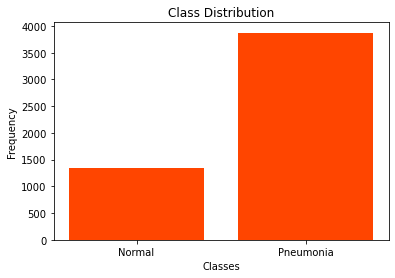

In [6]:
# Create sub-directory path objects within the training directory
normal_class = train_data_dir + '/NORMAL'
pneu_class = train_data_dir + '/PNEUMONIA'

# Get the class distribution
num_classes = {'Normal': len(os.listdir(normal_class)),
               'Pneumonia': len(os.listdir(pneu_class))}

# Plot the class distribution 
plt.bar(num_classes.keys(), num_classes.values(), color='orangered')
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.title('Class Distribution')
plt.show()

I see above that one class far outnumbers the other, which can skew the modeling results to favor predictions for that class. Therefore, I'll begin to oversample the data in order to model with a balanced dataset. I use the `RandomOverSampler` function to fit and resample my training data, then revert the oversampled training data to its original dimensions. 

In [7]:
# Reshape the labels
y_train_labels = train_labels.T[[1]]
y_test_labels = test_labels.T[[1]]
y_val_labels = val_labels.T[[1]]

# Check the shape of the transformed labels 
print(np.shape(y_train_labels))
print(np.shape(y_test_labels))
print(np.shape(y_val_labels))

(1, 5216)
(1, 524)
(1, 116)


In [8]:
# Reshaping the training data for oversampling
reshaped_train = train_images.reshape(train_images.shape[0],-1)

# Oversampling the training data
oversample = RandomOverSampler()
oversampled_X, oversampled_y = oversample.fit_resample(reshaped_train, y_train_labels.T)

# Reshaping the training data back to the original dimensions
sampled_train_images = oversampled_X.reshape(-1, 64, 64, 3)

In [9]:
# Calculate new class distribution
print('Resampled dataset shape', Counter(oversampled_y))

Resampled dataset shape Counter({0.0: 3875, 1.0: 3875})


The `Counter` function is used as a check, and confirms the classes have been balanced.

> Note: Reshaping the classes was only meant to examine whether the images truely corresponded with their labels. I confirm this with the two following image plots, where the first accurately displays a "normal", or healthy, image, and the second displays an image for a pneumonia-ridden patient. 

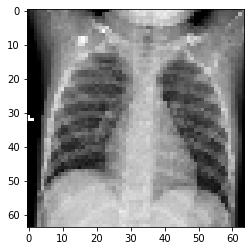

[0.]


In [10]:
# Confirm that the image matches with its corresponding label
plt.imshow(sampled_train_images[1400]/255)
plt.show()
print(y_train_labels[:, 1400])

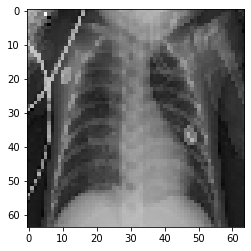

[1.]


In [11]:
# Confirm that the image matches with its corresponding label
plt.imshow(sampled_train_images[14]/255)
plt.show()
print(y_train_labels[:, 14])

## Modeling

### Baseline Model:
As I mentioned earlier, the initial reshaping was meant to view the images. Now, the training and validation images will need to be reshaped again, along with their labels, so that they contain the same first dimension. After, I standardize the images by dividing by 255 (due to the range of pixel intensity values falling between \[0, 255]\).

In [12]:
# Reshape the train, test, and validation images for modeling
X_train = sampled_train_images.reshape(7750, -1)
X_test = test_images.reshape(524, -1)
X_val = val_images.reshape(116, -1)

# Preview the shape of each newly-formed objects
print(np.shape(X_train))
print(np.shape(X_test))
print(np.shape(X_val))

(7750, 12288)
(524, 12288)
(116, 12288)


In [13]:
# Standardize the datasets
X_train_final = X_train/255
X_test_final = X_test/255
X_val_final = X_val/255

In [14]:
# Reshape the labels for modeling
y_train = np.reshape(oversampled_y, (7750, 1))
y_test = np.reshape(test_labels[:, 0], (524, 1))
y_val = np.reshape(val_labels[:, 0], (116, 1))

# Check the shape of the transformed labels 
print(np.shape(y_train))
print(np.shape(y_test))
print(np.shape(y_val))

(7750, 1)
(524, 1)
(116, 1)


Now that the data is fully manipulated, I begin building my baseline neural network by calling the `Sequential` function, then adding two `Dense` hidden layers with ReLu as my activation functions. I also pass in the input shape to create my input layer. The last layer acts as my output layer with a Sigmoid activation function. 

Once constructed, I compile the baseline model, using parameters I chose from prior research (links provided at the bottom). Therefore, `RMSprop` and binary cross-entropy will act as my optimizer and loss functions, respectively. I preview the model summary in order to highlight the number of parameters being trained in each layer, and the shape of the output. 

In [15]:
# Create a dense baseline neural network
baseline_model = Sequential()
baseline_model.add(Dense(32, activation='relu', input_shape=(12288, )))
baseline_model.add(Dense(8, activation='relu'))
baseline_model.add(Dense(1, activation='sigmoid'))

In [16]:
# Compile the baseline model
baseline_model.compile(loss='binary_crossentropy', optimizer='RMSprop', metrics=['acc'])

# List a summary of the baseline model
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                393248    
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 393,521
Trainable params: 393,521
Non-trainable params: 0
_________________________________________________________________


There are 393,521 different parameters being trained in this network, but only 1 value will be output. I fit the model to the training data and labels, while also using the validation data to further validate these results. I also set the number of epochs to 50, with a 64 image batch size.

In [17]:
# Fit the baseline model
baseline = baseline_model.fit(X_train_final, y_train, epochs=50, batch_size=64,
                                      validation_data=(X_val_final, y_val))

Epoch 1/50
122/122 [==============================] - 2s 12ms/step - loss: 0.5959 - acc: 0.7174 - val_loss: 1.7522 - val_acc: 0.4828
Epoch 2/50
122/122 [==============================] - 2s 14ms/step - loss: 0.4817 - acc: 0.8561 - val_loss: 1.3445 - val_acc: 0.1379
Epoch 3/50
122/122 [==============================] - 2s 15ms/step - loss: 0.4274 - acc: 0.8883 - val_loss: 2.5905 - val_acc: 0.4052
Epoch 4/50
122/122 [==============================] - 2s 14ms/step - loss: 0.3860 - acc: 0.9043 - val_loss: 3.6444 - val_acc: 0.4397
Epoch 5/50
122/122 [==============================] - 2s 15ms/step - loss: 0.3616 - acc: 0.9130 - val_loss: 3.1805 - val_acc: 0.3707
Epoch 6/50
122/122 [==============================] - 2s 14ms/step - loss: 0.3356 - acc: 0.9172 - val_loss: 0.9020 - val_acc: 0.4052
Epoch 7/50
122/122 [==============================] - 2s 15ms/step - loss: 0.3188 - acc: 0.9169 - val_loss: 3.6609 - val_acc: 0.3793
Epoch 8/50
122/122 [==============================] - 2s 15ms/step - 

In [18]:
# Evaluate the loss and accuracy scores for the training and validation datasets
print(f'Training data results:\n{baseline_model.evaluate(X_train_final, y_train)}')
print('\n')
print(f'Validation data results:\n{baseline_model.evaluate(X_val_final, y_val)}')

243/243 [==============================] - 1s 3ms/step - loss: 0.4499 - acc: 0.8516
Training data results:
[0.44989529252052307, 0.85161292552948]


4/4 [==============================] - 0s 2ms/step - loss: 4.3867 - acc: 0.1897
Validation data results:
[4.386716365814209, 0.18965516984462738]


The baseline results above generated a 85.2% accuracy rate for the training data, but only 19.0% for the validation data, which is horrible, and implies the model is overfitting to the training data. To get a better idea, I create a function that will visualize my training results going forward, and apply it to the baseline model.

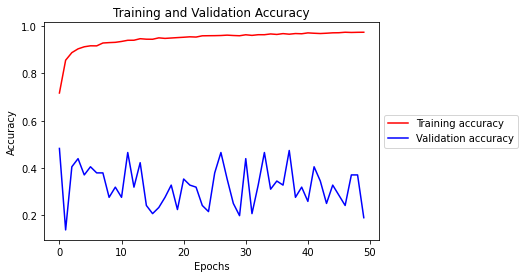

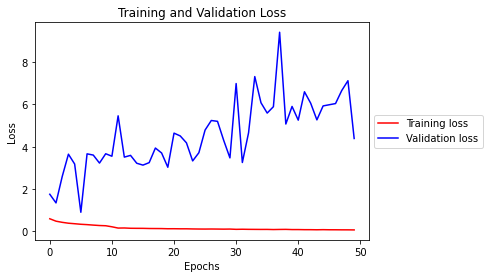

In [19]:
# Create a function that will visualize the training results for both datasets
def visualize_training_results(results):
    acc = results.history['acc']
    val_acc = results.history['val_acc']
    loss = results.history['loss']
    val_loss = results.history['val_loss']
    epochs = range(len(acc))
    
    plt.figure()
    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    
    plt.figure()
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

visualize_training_results(baseline)

The visuals above further confirm the overfitting theory. The large gaps in both the accuracies and losses serve as evidence, in addition to the training data's plots coming out rather clean when compared to the validation metrics. In order to eliminate the overfitting, I must tune the model.

### Regularizing the Baseline Model:
In order to reduce overfitting to the training data, I apply lasso (L2) regularization, specifically with a penalty of 0.01. The network architecture remains similar to the baseline's framework, with the exception of the L2 regularizer addition in the `kernel_regularizer` parameter. I fit the model with the same number of epochs and batch size, and evaluate the model with the validation data. 

In [20]:
# Regularize the baseline model
regularized_model = Sequential()
regularized_model.add(Dense(32, activation='relu', 
                            kernel_regularizer=regularizers.l2(0.01), input_shape=(12288, )))
regularized_model.add(Dense(8, activation='relu'))
regularized_model.add(Dense(1, activation = 'sigmoid'))
regularized_model.compile(loss='binary_crossentropy', 
                  optimizer='RMSprop', 
                  metrics=['acc'])
results = regularized_model.fit(X_train_final, y_train, epochs=50, batch_size=64,
                                      validation_data=(X_val_final, y_val))

Epoch 1/50
122/122 [==============================] - 2s 16ms/step - loss: 1.1665 - acc: 0.6338 - val_loss: 0.8103 - val_acc: 0.5000
Epoch 2/50
122/122 [==============================] - 2s 14ms/step - loss: 0.6914 - acc: 0.6884 - val_loss: 1.4975 - val_acc: 0.2155
Epoch 3/50
122/122 [==============================] - 2s 15ms/step - loss: 0.6333 - acc: 0.7608 - val_loss: 1.6341 - val_acc: 0.1724
Epoch 4/50
122/122 [==============================] - 2s 15ms/step - loss: 0.6303 - acc: 0.7925 - val_loss: 1.7870 - val_acc: 0.3966
Epoch 5/50
122/122 [==============================] - 2s 15ms/step - loss: 0.6738 - acc: 0.8053 - val_loss: 1.6960 - val_acc: 0.3017
Epoch 6/50
122/122 [==============================] - 2s 15ms/step - loss: 0.6896 - acc: 0.8108 - val_loss: 1.8386 - val_acc: 0.2672
Epoch 7/50
122/122 [==============================] - 2s 15ms/step - loss: 0.6361 - acc: 0.8164 - val_loss: 1.8955 - val_acc: 0.2328
Epoch 8/50
122/122 [==============================] - 2s 15ms/step - 

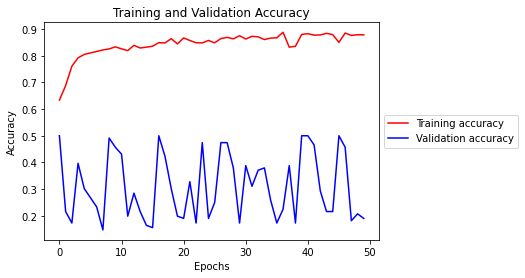

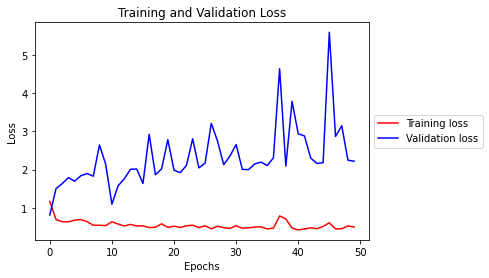

In [21]:
# Visualize the training results
visualize_training_results(results)

The baseline model is slightly better. I see that the data is overfitting less on the training data, and even more - the graphs for both datasets follow each other a little more closely (especially the loss line graph). Albeit far from perfect, the baseline model has improved, and I will cross-validate the results with Scikit-learn's `KFold` technique to see how generalizable this model is.

### Cross-Validating the Regularized Baseline Model:

I create a function that will build the regularized baseline model in order to cross-validate on it with `KFold`.

In [22]:
# Create a function that will build the regularized model above
def build_reg_model():
    regularized_model = Sequential()
    regularized_model.add(Dense(32, activation='relu', 
                            kernel_regularizer=regularizers.l2(0.01), input_shape=(12288, )))
    regularized_model.add(Dense(8, activation='relu'))
    regularized_model.add(Dense(1, activation = 'sigmoid'))
    regularized_model.compile(loss='binary_crossentropy', 
                  optimizer='RMSprop', 
                  metrics=['acc'])
    return regularized_model

I utilize SciKeras, which combines Scikit-learn's machine learning capabilities to further improve Keras's ability to build deep learning models. I'll use `KFold` to cross-validate and produce the average validation score.

In [23]:
# Cross-validate using scikit-learn tools
keras_model = scikit_learn.KerasClassifier(build_reg_model,
                                          epochs=32,
                                          batch_size=64,
                                          verbose=2)
kfold = KFold(shuffle=True, random_state=seed)
validation_scores = cross_val_score(keras_model, X_train_final, y_train, cv=kfold)

Epoch 1/32
97/97 - 1s - loss: 0.8153 - acc: 0.6129
Epoch 2/32
97/97 - 1s - loss: 0.6164 - acc: 0.7553
Epoch 3/32
97/97 - 1s - loss: 0.6966 - acc: 0.7245
Epoch 4/32
97/97 - 1s - loss: 0.5639 - acc: 0.7926
Epoch 5/32
97/97 - 1s - loss: 0.6256 - acc: 0.7829
Epoch 6/32
97/97 - 1s - loss: 0.5729 - acc: 0.7902
Epoch 7/32
97/97 - 1s - loss: 0.5478 - acc: 0.8116
Epoch 8/32
97/97 - 1s - loss: 0.5653 - acc: 0.8127
Epoch 9/32
97/97 - 1s - loss: 0.5567 - acc: 0.8147
Epoch 10/32
97/97 - 1s - loss: 0.5352 - acc: 0.8273
Epoch 11/32
97/97 - 1s - loss: 0.4994 - acc: 0.8427
Epoch 12/32
97/97 - 1s - loss: 0.6099 - acc: 0.8340
Epoch 13/32
97/97 - 1s - loss: 0.5387 - acc: 0.8250
Epoch 14/32
97/97 - 1s - loss: 0.5107 - acc: 0.8398
Epoch 15/32
97/97 - 1s - loss: 0.5517 - acc: 0.8447
Epoch 16/32
97/97 - 1s - loss: 0.4784 - acc: 0.8431
Epoch 17/32
97/97 - 1s - loss: 0.4561 - acc: 0.8548
Epoch 18/32
97/97 - 1s - loss: 0.4836 - acc: 0.8479
Epoch 19/32
97/97 - 1s - loss: 0.4485 - acc: 0.8568
Epoch 20/32
97/97 - 1

Epoch 29/32
97/97 - 1s - loss: 0.5794 - acc: 0.7748
Epoch 30/32
97/97 - 1s - loss: 0.5570 - acc: 0.8134
Epoch 31/32
97/97 - 1s - loss: 0.6220 - acc: 0.8124
Epoch 32/32
97/97 - 1s - loss: 0.6252 - acc: 0.7955
25/25 - 0s - loss: 0.7954 - acc: 0.6671


In [24]:
# Calculate the training data's average validation score
validation_scores.mean()

0.8193548440933227

Despite the slight improvement, the validation score being .819 suggests this model might have some promise, but still would not generalize well. Fortunately, this is just my foundation and a tool for comparison. 

For business purposes, it is also important I build a model that will cut down on the amount of false negatives (e.g, predicting a patient to be healthy when they actually have pneumonia). I plot a confusion matrix based on the test data to also compare at the end of my modeling process.

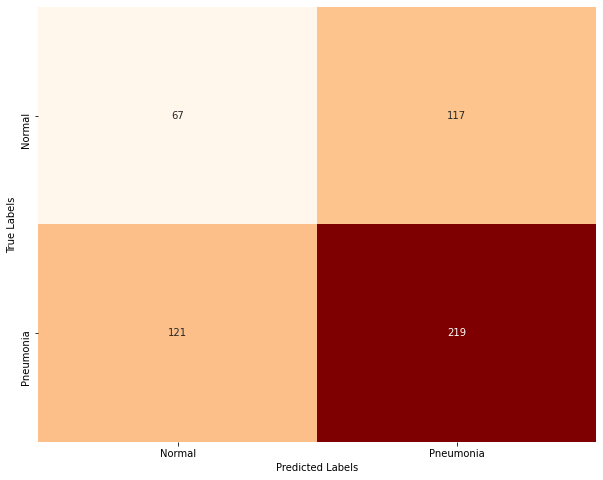

In [25]:
# Generate predictions and "round" the values
y_hat_test = regularized_model.predict(X_test_final)
y_test_baseline = test_generator.classes
y_hat_test[y_hat_test > 0.5] = 1
y_hat_test[y_hat_test < 0.5] = 0

# Plot a confusion matrix of the test data
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test_baseline, y_hat_test), annot=True,
           fmt='.3g', xticklabels=['Normal', 'Pneumonia'],
           yticklabels=['Normal', 'Pneumonia'], cmap='OrRd', cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

Although our model does well at recognizing pneumonia patients, the same cannot be said for healthy patients. In addition, the false negative count, which is 121, is pretty high. This also confirms the need for further work. 

## Further Modeling
### Convolutional Neural Network (CNN):
The next model I'd like to apply is a Convolutional Neural Network (CNN). The benefits to CNN models are that they're regularized, and are very efficient in analyzing image data. I start with my `Sequential` function, but then apply 3 convolutional layers with two different kernel shapes (`(3, 3)` and `(4, 4)`), and ReLu activation functions. After building my base, I apply `Flatten` and two `Dense` functions to produce a hidden layer before my output layer. I compile and fit the model before visualizing the results.

In [26]:
# Construct the CNN model's framework
CNNmodel = Sequential()
CNNmodel.add(Conv2D(32, (3, 3), activation='relu',
                        input_shape=(64 ,64,  3)))
CNNmodel.add(MaxPooling2D((2, 2)))

CNNmodel.add(Conv2D(32, (4, 4), activation='relu'))
CNNmodel.add(MaxPooling2D((2, 2)))

CNNmodel.add(Conv2D(64, (3, 3), activation='relu'))
CNNmodel.add(MaxPooling2D((2, 2)))

CNNmodel.add(Flatten())
CNNmodel.add(Dense(64, activation='relu'))
CNNmodel.add(Dense(1, activation='sigmoid'))

CNNmodel.compile(loss='binary_crossentropy',
              optimizer="RMSprop",
              metrics=['acc'])

In [27]:
# Fit the CNN model
CNNresults = CNNmodel.fit(sampled_train_images,
                    y_train,
                    epochs=50,
                    batch_size=64,
                    validation_data=(val_images, y_val))

Epoch 1/50
122/122 [==============================] - 23s 187ms/step - loss: 2.6914 - acc: 0.7579 - val_loss: 2.5803 - val_acc: 0.1466
Epoch 2/50
122/122 [==============================] - 22s 183ms/step - loss: 0.2538 - acc: 0.9075 - val_loss: 5.8810 - val_acc: 0.3621
Epoch 3/50
122/122 [==============================] - 22s 182ms/step - loss: 0.1936 - acc: 0.9430 - val_loss: 5.8408 - val_acc: 0.2672
Epoch 4/50
122/122 [==============================] - 22s 182ms/step - loss: 0.1240 - acc: 0.9604 - val_loss: 6.8643 - val_acc: 0.2759
Epoch 5/50
122/122 [==============================] - 22s 182ms/step - loss: 0.0926 - acc: 0.9703 - val_loss: 8.6874 - val_acc: 0.2155
Epoch 6/50
122/122 [==============================] - 22s 182ms/step - loss: 0.1393 - acc: 0.9728 - val_loss: 9.4028 - val_acc: 0.2759
Epoch 7/50
122/122 [==============================] - 22s 180ms/step - loss: 0.0900 - acc: 0.9738 - val_loss: 7.5760 - val_acc: 0.2586
Epoch 8/50
122/122 [==============================] - 2

The plots below exhibit some overfitting, once again. The accuracy plot shows a wide gap between the training and validation accuracies, while the loss plots show the training loss increasing as the number of epochs does too. Therefore, while the CNN model has improved the scores, the overfitting is still an issue. With CNN algorithms having built-in regularization methods, I'll look to combat this overfitting by adding more data. 

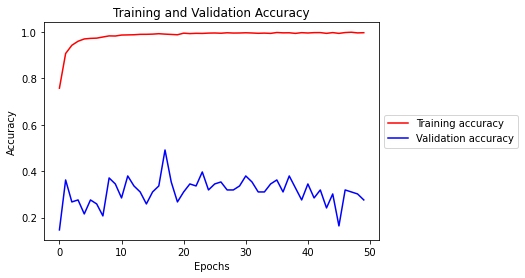

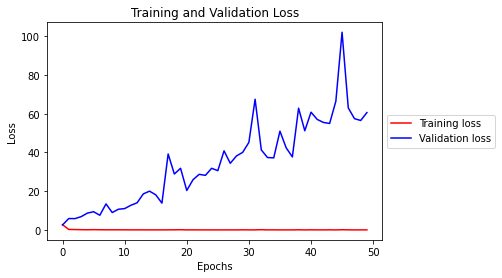

In [28]:
# Visualize the training results
visualize_training_results(CNNresults)

### Data Augmentation
In order to improve my model further, I'll increase my training size by applying data augmentation. However, in order to preserve the class balance I established earlier, I'll be using a class I obtained from prior research (the link is provided at the bottom of the notebook). The class `BalancedDataGenerator` takes in the unbalanced data and applies both data augmentation and `RandomOverSampling` to create more data while preserving the class balance. 

Considering the images are X-rays, I select my parameters within `ImageDataGenerator` carefully and logically (i.e., increasing brightness to better detect abstract features, zooming in, flipping the image, etc.). I'll reload the training images with these new parameters, as well as the validation and test images (which will also be standardized). 

In [29]:
# Reshape the training data for augmentation 
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=15, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   brightness_range=[1, 1.5], 
                                   zoom_range=0.2, 
                                   horizontal_flip=True)

In [30]:
# Create the BalancedDataGenerator class (obtained from research)
class BalancedDataGenerator(Sequence):
    # Data augmentation and RandomOversampling
    def __init__(self, x, y, datagen, batch_size=32):
        self.datagen = datagen
        self.batch_size = min(batch_size, x.shape[0])
        datagen.fit(x)
        self.gen, self.steps_per_epoch = balanced_batch_generator(
            x.reshape(x.shape[0], -1), y, sampler=RandomOverSampler(),
            batch_size=self.batch_size, keep_sparse=True)
        self._shape = (self.steps_per_epoch * batch_size, *x.shape[1:])
        
    def __len__(self):
        return self.steps_per_epoch

    def __getitem__(self, idx):
        x_batch, y_batch = self.gen.__next__()
        x_batch = x_batch.reshape(-1, *self._shape[1:])
        return self.datagen.flow(x_batch, y_batch, batch_size=self.batch_size).next()

In [31]:
# Reshape the training labels
y_unbalanced = np.reshape(train_labels[:, 0], (5216, 1))

In [32]:
# Oversample and augment the training data
balanced_generator = BalancedDataGenerator(train_images, y_unbalanced, train_datagen, batch_size=32)

# Get all the data in the test directory and standardize
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_data_dir, target_size=(64, 64), 
    batch_size = 524, seed=seed, class_mode='binary') 

# Get all the data in the validation directory (in batches) and standardize
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    validation_dir, target_size=(64, 64),
    batch_size = 116, seed=seed, class_mode='binary')

Found 524 images belonging to 2 classes.
Found 116 images belonging to 2 classes.


Now that the images have been loaded again, I will rebuild my CNN model; however, I will also alter the learning rate in order to improve my CNN model further. 

In [33]:
# Build a CNN model framework using the augmented training data
augCNNmodel = Sequential()
augCNNmodel.add(Conv2D(32, (3, 3), activation='relu',
                        input_shape=(64 ,64,  3)))
augCNNmodel.add(MaxPooling2D((2, 2)))

augCNNmodel.add(Conv2D(32, (4, 4), activation='relu'))
augCNNmodel.add(MaxPooling2D((2, 2)))

augCNNmodel.add(Conv2D(64, (3, 3), activation='relu'))
augCNNmodel.add(MaxPooling2D((2, 2)))

augCNNmodel.add(Flatten())
augCNNmodel.add(Dense(64, activation='relu'))
augCNNmodel.add(Dense(1, activation='sigmoid'))

augCNNmodel.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=0.01),
              metrics=['acc'])

I'm also going to create a stopping condition, due to the runtime given the size of the dataset and number of epochs. I'll set that stopping point as a checkpoint with `ModelCheckpoint`, so that I can evaluate the saved model further along the process. Once my conditions have been set, I'll fit the model with these callbacks.

In [34]:
# Create a file name object for the best model checkpoint
model_filepath = 'best_aug_model.h5'

# Set early stopping and model checkpoint conditions
early_stopping = [EarlyStopping(monitor='val_loss', patience=5), 
                  ModelCheckpoint(filepath=model_filepath, monitor='val_loss', save_best_only=True)]

In [35]:
# Fit the data-augmented CNN model
augCNNresults = augCNNmodel.fit(balanced_generator,
                                epochs=32,
                                callbacks=early_stopping,
                                validation_data=val_generator)

Epoch 1/32
242/242 [==============================] - 33s 137ms/step - loss: 2.2481 - acc: 0.6485 - val_loss: 1.2938 - val_acc: 0.3534
Epoch 2/32
242/242 [==============================] - 33s 136ms/step - loss: 0.5805 - acc: 0.7292 - val_loss: 1.3879 - val_acc: 0.3707
Epoch 3/32
242/242 [==============================] - 33s 136ms/step - loss: 0.5241 - acc: 0.7473 - val_loss: 1.3022 - val_acc: 0.3103
Epoch 4/32
242/242 [==============================] - 33s 134ms/step - loss: 0.4389 - acc: 0.7994 - val_loss: 1.7904 - val_acc: 0.2241
Epoch 5/32
242/242 [==============================] - 33s 138ms/step - loss: 0.3981 - acc: 0.8304 - val_loss: 1.6123 - val_acc: 0.1638
Epoch 6/32
242/242 [==============================] - 33s 136ms/step - loss: 0.3817 - acc: 0.8465 - val_loss: 2.2738 - val_acc: 0.1983


The data-augmented CNN model stopped at 6 epochs, suggesting that is the best point in the model where the validation loss plateaus. The model is saved as `'best_aug_model.h5'`, and I'll load the model in order to evaluate both the training and validation datasets.

In [36]:
# Load the best (saved) model for the augmented data
saved_model = load_model(model_filepath)

# Calculate the loss and accuracy scores for both training datasets
results_train = saved_model.evaluate(balanced_generator)
print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')

print('----------')

results_val = saved_model.evaluate(val_generator)
print(f'Validation Loss: {results_val[0]:.3} \nValidation Accuracy: {results_val[1]:.3}')

242/242 [==============================] - 18s 74ms/step - loss: 0.7032 - acc: 0.7332
Training Loss: 0.703 
Training Accuracy: 0.733
----------
1/1 [==============================] - 0s 2ms/step - loss: 1.2938 - acc: 0.3534
Validation Loss: 1.29 
Validation Accuracy: 0.353


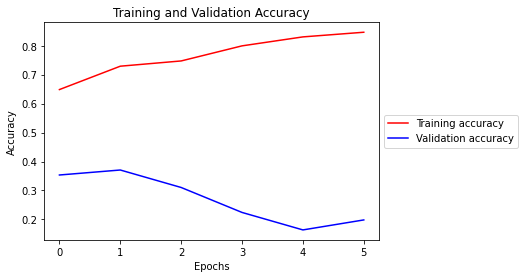

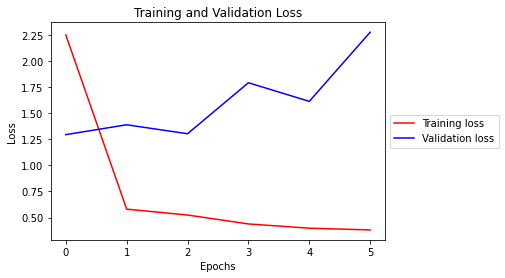

In [37]:
# Plot the training results
visualize_training_results(augCNNresults)

While the validation data's accuracy increased to 35.3%, the results are still horrible. The gaps between the accuracies has narrowed as well, which conveys this model is combatting the overfitting issue better than the previous model. 

I also visualize the training results above. One can see the validation metrics are plotted much cleaner, and with less "noise"; however, by no means is this a reliable algorithm. The two metrics seem to almost mimic each other in their directions to begin the accuracy plots, but then diverge. With further tuning, they might reflect each other better. 

### Transfer Learning Approach:
One last approach I want to test out is the transfer learning approach. Transfer learning allows me to utilize pre-trained networks as a base to my model, with the option to build additional layers for specific feature extraction or fine tuning. I researched various pre-trained networks, and selected `ResNet50` due to its high accuracy and application in medical imaging (link to research located at the bottom). 

I print the summary, after instantiating the network, to examine the number of parameters my model will be training - shown to be 23,534,592 parameters!

In [38]:
# Instantiate the CNN base object
cnn_base = ResNet50(weights='imagenet', 
                 include_top=False, 
                 input_shape=(64, 64, 3))

# Preview the various parameters that will be trained
cnn_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

After building the CNN base, I add additional layers (specifically 1 hidden and the output) in order to better analyze the more abstract features within my images. Then, I freeze the base model, and compile my model to fit on the training data (and evaluated by the validation data). I list all the trainable layers and weights as a sanity check to review my work.

In [39]:
# Build a network with the CNN base
resnet_model = Sequential()
resnet_model.add(cnn_base)
resnet_model.add(Flatten())
resnet_model.add(Dense(256, activation='relu'))
resnet_model.add(Dense(1, activation='sigmoid'))

# Freeze the base model
cnn_base.trainable = False

# List all the trainable layers
for layer in resnet_model.layers:
    print(layer.name, layer.trainable)
    
# Similarly, check how many trainable weights are in the model 
print(f'Trainable weights: {len(resnet_model.trainable_weights)}\n')

# Preview the various parameters and output shapes, once again
resnet_model.summary()

resnet50 False
flatten_2 True
dense_25 True
dense_26 True
Trainable weights: 4

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2, 2, 2048)        23587712  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_25 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 257       
Total params: 25,685,377
Trainable params: 2,097,665
Non-trainable params: 23,587,712
_________________________________________________________________


> Note: I only run the model for 10 epochs in order to cut on the training time.

In [40]:
# Compile the transfer learning model
resnet_model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=0.01),
              metrics=['acc'])

# Fit the model
resnet_results = resnet_model.fit(balanced_generator,
                              epochs=10,
                              validation_data=val_generator)

Epoch 1/10
242/242 [==============================] - 88s 363ms/step - loss: 0.7497 - acc: 0.6797 - val_loss: 1.3751 - val_acc: 0.1552
Epoch 2/10
242/242 [==============================] - 85s 352ms/step - loss: 0.5144 - acc: 0.7476 - val_loss: 1.5548 - val_acc: 0.2586
Epoch 3/10
242/242 [==============================] - 89s 368ms/step - loss: 0.4861 - acc: 0.7691 - val_loss: 1.9027 - val_acc: 0.2069
Epoch 4/10
242/242 [==============================] - 86s 354ms/step - loss: 0.4659 - acc: 0.7801 - val_loss: 1.7360 - val_acc: 0.1724
Epoch 5/10
242/242 [==============================] - 85s 351ms/step - loss: 0.4745 - acc: 0.7779 - val_loss: 1.6041 - val_acc: 0.1983
Epoch 6/10
242/242 [==============================] - 90s 373ms/step - loss: 0.4704 - acc: 0.7788 - val_loss: 1.8178 - val_acc: 0.2155
Epoch 7/10
242/242 [==============================] - 87s 358ms/step - loss: 0.4597 - acc: 0.7850 - val_loss: 2.2639 - val_acc: 0.3276
Epoch 8/10
242/242 [==============================] - 8

Now that the model has been run, I plot the training results with different markers to better exhibit how the model performed.

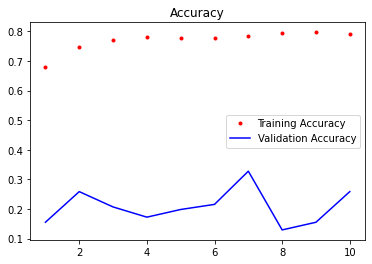

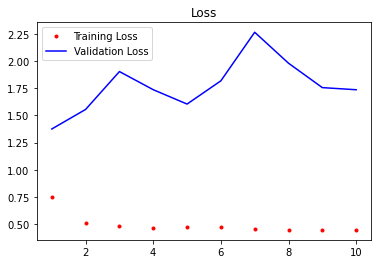

In [41]:
# Plot the training results using different markers
resnet_train_acc = resnet_results.history['acc']
resnet_val_acc = resnet_results.history['val_acc']
resnet_train_loss = resnet_results.history['loss']
resnet_val_loss = resnet_results.history['val_loss']
epch = range(1, len(resnet_train_acc) + 1)

plt.plot(epch, resnet_train_acc, 'r.', label='Training Accuracy')
plt.plot(epch, resnet_val_acc, 'b', label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.figure()
plt.plot(epch, resnet_train_loss, 'r.', label='Training Loss')
plt.plot(epch, resnet_val_loss, 'b', label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.show()

As shown above, the transfer learning model did worse than our CNN model, even with the data augmentation approach! The validation accuracy and loss gets "noisier", and alternates between decreasing and increasing slopes. Compared to the training data, the validation data suggests the model needs to be tuned further, or perhaps needs another pre-trained network to build off of.

## Deployment & Evaluation
After reviewing the training and validation scores, I've determined the CNN model with the augmented data is the best at classifying my X-ray images. Fortunately, this model was saved by `ModelCheckpoint`, and loaded earlier in the notebook; therefore, evaluating the testing dataset is simple.

In [42]:
# Evaluate the test data and list testing accuracy
test_loss, test_acc = saved_model.evaluate(test_generator)
y_hat_test = saved_model.predict(test_generator)
print('Generated {} predictions'.format(len(y_hat_test)))
print('test acc:', test_acc)

1/1 [==============================] - 0s 2ms/step - loss: 1.1847 - acc: 0.4027
Generated 524 predictions
test acc: 0.402671754360199


My saved model is 40.3% accurate after analyzing the testing data, which is decent given the validation accuracies performing worse, but obviously leaves room for improvement. Below I plot the confusion matrix to get a further look at how the model performed. 

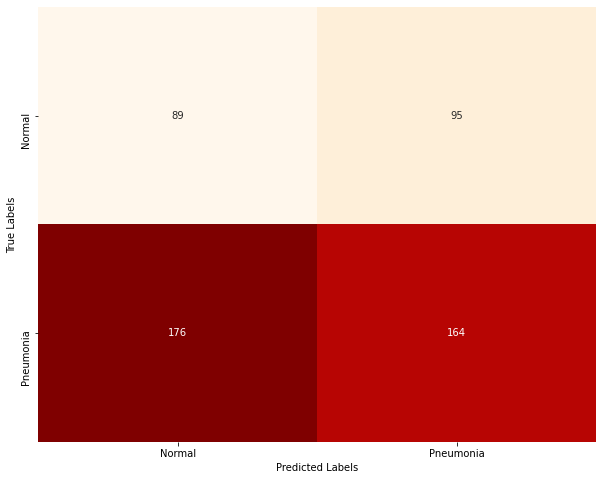

In [43]:
# Set conditions to make plotting the confusion matrix easier
y_test = test_generator.classes
y_hat_test[y_hat_test > 0.5] = 1
y_hat_test[y_hat_test < 0.5] = 0

# Plot a confusion matrix of the test data
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test, y_hat_test), annot=True,
           fmt='.3g', xticklabels=['Normal', 'Pneumonia'],
           yticklabels=['Normal', 'Pneumonia'], cmap='OrRd', cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

The visual above further confirms this model needs to be improved, especially in its false negative count (predicting "Normal" when the patient actually has pneumonia!). Unfortunately, the count rose from our baseline model, 121, to 176 in our final model. However, the positive class is being identified correctly, suggesting that the class imbalance is still affecting the models. However, after some further tuning, I'm confident the model can be generalized to a level where it can be deployed for use.

## Conclusion

This analysis leads to the following conclusions:

1. The Convolutional Neural Network (CNN) model performs the best in image classification; specifically, when the data has been augmented. 


2. The model is 40.3% accurate when testing and classifying chest X-ray images for pneumonia.

## Limitations & Further Work

This project is limited in a few ways, the first being the lack of data. It wasn't until I augmented my data that the model began to train better, and yield efficient results. If given more image data, the model could effectively learn more of the abstract features within the X-ray images to better identify between the two groups of patients. Also, training the models with a more balanced class distribution so that I can tackle the issue of false negatives. In addition, computational constraints limit my ability to iterate the model with more epochs. If I were to increase my epochs, or even add more GPUs for modeling, I could potentially improve my results. There are other hyperparameters I could test, as well, which might also improve the algorithm's performance.

Further analyses could yield a more effective classifier, and possibly improve the algorithm's performance. Some possible courses of action I could take include training with other pre-trained networks. The research I found led me to pre-select a base model; however, I could train a few more that may examine the training images better, and improve my results. In addition, I could balance my class distribution better, which would reduce the amount of "noise" shown in my visuals for the validation data's metrics, but also give me a better idea on how to further develop my classifier.

## Sources

**Original dataset:**
1. https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia


**Research that led to parameter preselection (i.e. optimizer, loss function, etc.):**
1. https://www.sciencedirect.com/science/article/pii/S2214785321013316/pdfft?md5=e75aaffc3f03bcc370288811c870b7d9&pid=1-s2.0-S2214785321013316-main.pdf
    
2. https://towardsai.net/p/l/impact-of-optimizers-in-image-classifiers    


**Source of the `BalancedDataGenerator()` class:**
1. https://gist.github.com/arnaldog12/16efc663c869b35e2479bd607d56c1da